In [2]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
from sympy import Symbol, sin, cos, sec, tan, Matrix, integrate, eye, latex
import os
import cvxpy as cp
from linearizedcar import DubinsCar, dubinsCurve2d, Vertex

(CVXPY) Dec 11 04:36:25 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [3]:
# system variables
rho = 1
length = 1
u_psi = 5
phi_max = np.pi/6

r_min = length / (np.tan(phi_max))

In [4]:
def nonlinearCar(q: np.ndarray, u: np.ndarray, t: float):
    return np.array([
        rho * np.cos(q[2]),
        rho * np.sin(q[2]),
        rho / length * np.tan(q[4]),
        u[0],
        u[1],
        u[2]
    ])

def aMat(t: float, qt: np.ndarray, ut: np.ndarray):
    A = np.zeros([6, 6])
    A[0, 2] = - ut[0] * rho * np.sin(qt[2])
    A[1, 2] = ut[0] * rho * np.cos(qt[2])
    A[2, 4] = ut[0] * rho / length * np.cos(qt[4]) ** -2
    return A

def bMat(t: float, qt: np.ndarray, ut: np.ndarray):
    B = np.zeros([6, 3])
    B[0, 0] = rho * np.cos(qt[2])
    B[1, 0] = rho * np.sin(qt[2])
    B[2, 0] = rho / length * np.tan(qt[4])
    B[3, 0] = 1
    B[4, 1] = 1
    B[5, 2] = 1
    return B

def linearizedCar(q: np.ndarray, u: np.ndarray, t: float, q_tilde: 'Callable[[float], np.ndarray]', u_tidle: 'Callable[[float], np.ndarray]'):
    qt = q_tilde(t)
    ut = u_tidle(t)
    f = nonlinearCar(qt, ut, t)
    A = aMat(t, qt, ut)
    B = bMat(t, qt, ut)
    return f + np.matmul(A, q - qt) + np.matmul(B, u - ut)



In [5]:
def straightLineGenerator(x0, y0, theta0, v):
    def f(t):
        return np.ndarray([
            x0 + v * rho * np.cos(theta0) * t,
            x0 + v * rho * np.cos(theta0) * t,
            0,
            v * t,
            0,
            0
        ])

def curvePathGenerator(x0, y0, theta0, theta_dot, phi, v):
    r = length / np.tan(phi)
    if phi > 0: # left
        perp = theta0 + np.pi / 2
    else: # right
        perp = theta0 - np.pi / 2
    xc = r * np.cos(perp) + x0
    yc = r * np.sin(perp) + y0
    def f(t):
        return np.ndarray([
            xc + r * np.cos(theta_dot * t + theta0),
            yc + r * np.sin(theta_dot * t + theta0),
            theta_dot * t,
            v * t,
            phi,
            0
        ])
    return f


$\Phi[k, k_0] = A[k -1]A[k-2]\cdots A[k_0]$


$x[k] = \Phi[k, k_0]x_0 + \sum_{m=k_0}^{k-1}\Phi[k, m + 1]B[m]u[m]$


$k_0 = k-1$


$x[k] = \Phi[k, k-1]x_{k-1} + \Phi[k, k-1]B[k-1]u[k-1]$


$x[k] = A[k-1]x_{k-1} + A[k-1]B[k-1]u[k-1]$

In [6]:
def straightAmat(h, rho, length, u_psi, theta_0):
    return np.array([
        [1, 0, -u_psi * rho * np.sin(theta_0) * h, 0, 0, 0],
        [0, 1, u_psi * rho * np.cos(theta_0) * h, 0, 0, 0],
        [0, 0, 1, 0, u_psi * rho / length * h, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])

def straightBmat(h, rho, length, u_psi, theta_0):
    return np.array([
        [rho * np.cos(theta_0) * h, 0, 0],
        [rho * np.sin(theta_0) * h, 0, 0],
        [0, 0, 0],
        [h, 0, 0],
        [0, h, 0],
        [0, 0, h]
    ])

def straightDmat(h, rho, u_psi, theta_0):
    return np.array([
        rho * u_psi * np.cos(theta_0) * h,
        rho * u_psi * np.sin(theta_0) * h,
        0,
        u_psi * h,
        0,
        0
    ])

In [6]:
u_psi = Symbol('u_psi')
h = Symbol('h')
rho = Symbol('rho')
t = Symbol('t')
theta = Symbol('theta')
l = Symbol('l')
phi = Symbol('phi')

A = Matrix([
    [ 0, 0, -u_psi * rho * sin(theta), 0, 0, 0],
    [ 0, 0, u_psi * rho * cos(theta), 0, 0, 0],
    [ 0, 0, 0, 0,u_psi * rho / l * sec(phi) ** 2 , 0],
    [ 0, 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0, 0],
])
B = Matrix([
    [rho * cos(theta), 0, 0],
    [rho * sin(theta), 0, 0],
    [rho / l * tan(phi), 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])
A * A * A

Matrix([
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0]])

In [7]:
u_psi = Symbol('u_psi')
h = Symbol('h')
rho = Symbol('rho')
t = Symbol('t')
k = Symbol('k')
t_0 = Symbol('t_0')
theta_0 = Symbol('theta_0')
theta_dot = Symbol('thetadot', nonzero=True)
l = Symbol('l')
phi_c = Symbol('phi_c')

A = Matrix([
    [ 0, 0, -u_psi * rho * sin(theta_dot * t + theta_0), 0, 0, 0],
    [ 0, 0, u_psi * rho * cos(theta_dot * t + theta_0), 0, 0, 0],
    [ 0, 0, 0, 0,u_psi * rho / l * sec(phi_c) ** 2 , 0],
    [ 0, 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0, 0],
])
B = Matrix([
    [rho * cos(theta_dot * t + theta_0), 0, 0],
    [rho * sin(theta_dot * t + theta_0), 0, 0],
    [rho / l * tan(phi_c), 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

D = Matrix([
    rho * u_psi * cos(theta_dot * t + theta_0),
    rho * u_psi * sin(theta_dot * t + theta_0),
    rho / l * u_psi * tan(phi_c),
    u_psi,
    0,
    0
])
t_0 = 0
    

def Phi(r, tau):
    return eye(6) + integrate(A, (t, tau, r)) + integrate(A * integrate(A, (t, tau, t)), (t, tau , r))

F = Phi(h * (k+1) + t_0, k * h + t_0)
s = Symbol('s')
B = B.subs(t, s)
D = D.subs(t, s)
G = integrate(Phi(h * k + t_0, s) * B, (s, t_0 + h * k, h * (k+1) + t_0))
H = integrate(Phi(h * k + t_0, s) * D, (s, t_0 + h * k, h * (k+1) + t_0))

if not os.path.exists('target'):
    os.mkdir('target')

with open('target/A[k].tex', 'w') as f:
    f.write(latex(F.simplify()))

with open('target/B[k].tex', 'w') as f:
    f.write(latex(G.simplify()))

with open('target/D[k].tex', 'w') as f:
    f.write(latex(H.simplify()))



In [8]:
def curveAmat(h, rho, length, u_psi, theta_0, theta_dot, phi_c):
    def f(k):
        return np.array([
        [1, 0,
            rho * u_psi * ( -np.cos(h * k * theta_dot + theta_0) + np.cos(h * theta_dot * (k + 1) + theta_0)) / theta_dot, 0,
            rho ** 2 * u_psi ** 2 * (h * theta_dot * np.cos(h * theta_dot * (k + 1) + theta_0) + np.sin(h * k * h * theta_dot + theta_0) - np.sin(h * theta_dot * (k + 1) + theta_0)) / (np.cos(phi_c) ** 2 * length * theta_dot ** 2), 0],
        [1, 0,
            rho * u_psi * ( -np.sin(h * k * theta_dot + theta_0) + np.sin(h * theta_dot * (k + 1) + theta_0)) / theta_dot, 0,
            rho ** 2 * u_psi ** 2 * (h * theta_dot * np.sin(h * theta_dot * (k + 1) + theta_0) - np.cos(h * k * h * theta_dot + theta_0) + np.cos(h * theta_dot * (k + 1) + theta_0)) / (np.cos(phi_c) ** 2 * length * theta_dot ** 2), 0],
        [0, 0, 1, 0, h * u_psi * rho / (np.cos(phi_c) ** 2 * length), 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
        ])
    return f

def curveBmat(h, rho, length, u_psi, theta_0, theta_dot, phi_c):
    def f(k):
        return np.array([
            [rho * (length * theta_dot * (-np.sin(h * k * theta_dot + theta_0) + np.sin(h * theta_dot * (k + 1) + theta_0)) + rho * u_psi * (h * theta_dot * np.cos(h * k * theta_dot + theta_0) + np.sin(h * k * theta_dot + theta_0) - np.sin(h * theta_dot * (k + 1) + theta_0)) * np.tan(phi_c)) / (length * theta_dot ** 2),
            rho ** 2 * u_psi ** 2 * (-.5 * h ** 2 * theta_dot ** 2 * np.cos(h * k * theta_dot + theta_0) - h * theta_dot * np.sin(h * k * theta_dot + theta_0) + np.cos(h * k * theta_dot + theta_0) - np.cos(h * theta_dot * (k + 1) + theta_0)) / (length * theta_dot ** 3 * np.cos(phi_c) ** 2), 0],
            [rho * (length * theta_dot * (np.cos(h * k * theta_dot + theta_0) - np.cos(h * theta_dot * (k + 1) + theta_0)) + rho * u_psi * (h * theta_dot * np.sin(h * k * theta_dot + theta_0) - np.cos(h * k * theta_dot + theta_0) + np.cos(h * theta_dot * (k + 1) + theta_0)) * np.tan(phi_c)) / (length * theta_dot ** 2),
            rho ** 2 * u_psi ** 2 * (-.5 * h ** 2 * theta_dot ** 2 * np.sin(h * k * theta_dot + theta_0) + h * theta_dot * np.cos(h * k * theta_dot + theta_0) + np.sin(h * k * theta_dot + theta_0) - np.sin(h * theta_dot * (k + 1) + theta_0)) / (length * theta_dot ** 3 * np.cos(phi_c) ** 2), 0],
            [h * rho * np.tan(phi_c) / length, h ** 2 * rho * u_psi /(2 * length * np.cos(phi_c) ** 2), 0],
            [h, 0, 0],
            [0, h, 0],
            [0, 0, h]
        ])
    return f

def curveDmat(h, rho, length, u_psi, theta_0, theta_dot, phi_c):
    def f(k):
        return np.array([
            rho * u_psi * (length * theta_dot * (-np.sin(h * k * theta_dot + theta_0) + np.sin(h * theta_dot * (k + 1) + theta_0)) + rho * u_psi * (h ( theta_dot * np.cos(h * k * theta_dot + theta_0) + np.sin(h * k * theta_dot + theta_0) - np.sin(h * theta_dot * (k + 1) + theta_0)) * np.tan(phi_c))) / (length * theta_dot ** 2),
            rho * u_psi * (length * theta_dot * (np.cos(h * k * theta_dot + theta_0) - np.cos(h * theta_dot * (k + 1) + theta_0)) + rho * u_psi * (h ( theta_dot * np.sin(h * k * theta_dot + theta_0) - np.cos(h * k * theta_dot + theta_0) + np.cos(h * theta_dot * (k + 1) + theta_0)) * np.tan(phi_c))) / (length * theta_dot ** 2),
            h * rho * u_psi * np.tan(phi_c) / length,
            u_psi * h,
            0,
            0
        ])
    return f

c:\Users\chagu\Programs\repos\LinearizedCarRobot\linearizedcar\dubinsCar.py:164: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt((x + m_sth) * (x + m_sth) + (y - m_cth - 1) * (y - m_cth - 1) - 4)
c:\Users\chagu\Programs\repos\LinearizedCarRobot\linearizedcar\dubinsCar.py:299: RuntimeWarning: invalid value encountered in arccos
  possibleB.append(np.arccos(1 - (v ** 2 + w ** 2) / 2))
c:\Users\chagu\Programs\repos\LinearizedCarRobot\linearizedcar\dubinsCar.py:256: RuntimeWarning: invalid value encountered in arccos
  possibleB.append(np.arccos(1 - (v ** 2 + w ** 2) / 2))


Text(0, 0.5, 'y (m)')

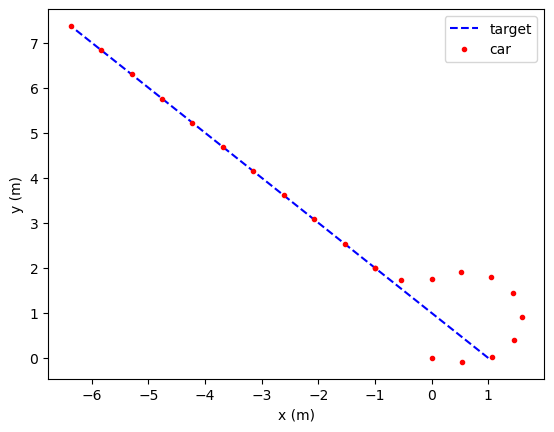

In [25]:
dt = .1
r = 1

# target dynamics
# x[k+1] = I x[k] + dt u
u_t = np.array([-1.0, 1.0, 0])
u_t /= np.linalg.norm(u_t) * .95

T = 100
x_t = np.zeros([3, T])
x_t[:, 0] = [1, 0, 5]
for k in range(T - 1):
    x_t[:, k + 1] = x_t[:, k] + dt * u_t

fig = plt.figure()
ax = fig.gca()
ax.plot(x_t[0, :], x_t[1, :], 'b--')

planner = DubinsCar()
# car start
start = Vertex(x=0, y=0, psi=0)
end = Vertex(x=-1, y=2, psi=3/4 * np.pi)
path = planner.calculatePath(start, end, r)
f = dubinsCurve2d(path.start.toarray(), path.a, path.b, path.c, path.r, path.type)
p = np.array([f(s) for s in np.arange(0, 1.01, dt)])
ax.plot(p[:, 0], p[:, 1], 'r.')

final = Vertex(x=x_t[0, -1], y=x_t[1, -1], psi=3/4 * np.pi)
path = planner.calculatePath(end, final, r)
f = dubinsCurve2d(path.start.toarray(), path.a, path.b, path.c, path.r, path.type)
p = np.array([f(s) for s in np.arange(0, 1.01, dt)])
ax.plot(p[:, 0], p[:, 1], 'r.')

ax.legend(['target', 'car'])
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
fig.savefig('target/trajectories.pdf')

In [ ]:
Q = np.eye(6)
R = np.eye(6)

q = cp.Variable(6)